In [1]:
#import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy import ndimage
import math

C:\Users\aabil\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


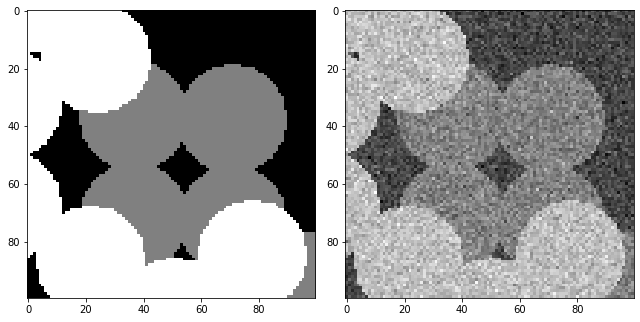

In [2]:
img_true = imageio.imread('data/data/noise_free_circles.png').astype(float)
img_noise = imageio.imread('data/data/noisy_circles.png').astype(float)

fig1, f1_axes = plt.subplots(ncols=2, nrows=1, constrained_layout=False, figsize=(9,6))
f1_axes[0].imshow(img_true, cmap = "gray")
f1_axes[1].imshow(img_noise, cmap = "gray")
fig1.show()
fig1.tight_layout()

In [3]:
print(img_true)

[[190. 190. 190. ...  70.  70.  70.]
 [190. 190. 190. ...  70.  70.  70.]
 [190. 190. 190. ...  70.  70.  70.]
 ...
 [ 70.  70.  70. ... 130. 130. 130.]
 [ 70.  70.  70. ... 130. 130. 130.]
 [ 70.  70.  70. ... 130. 130. 130.]]


Create histogram:

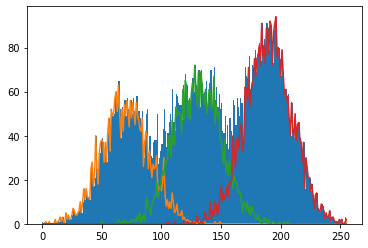

In [4]:
def segmentationHistogram(img_true, img_noise, chist=True):
    hist_graph = np.zeros((3, 255))
    
    classes = {70. : 0,
               130. : 1,
               190. : 2}
    
    for i, row in enumerate(img_true):
        for j, _ in enumerate(row):
            intensity = math.floor(img_noise[i,j])-1
            if chist:
                clss = classes[img_true[i,j]]
                hist_graph[clss, intensity] +=1

    plt.hist(img_noise.flatten(), bins=255)
    if chist:
        plt.plot(np.array(range(255))+1, hist_graph[0,:])
        plt.plot(np.array(range(255))+1, hist_graph[1,:])
        plt.plot(np.array(range(255))+1, hist_graph[2,:])
    plt.show()
    return

segmentationHistogram(img_true, img_noise)

### What does the histogram say about obtaining an image segmentation using e.g. thresholding?
From the histogram we see, that any segmentation method only considering the pixel intensities will have a considerable error-rate. From decision theory we have, that the such a method ideally would consider.....

### A function to compute segmentation energies is implemented:

It should be noted, that the edges are not considered.

In [5]:
alpha = 0.0005

def V2(f1, f2):
    if f1==f2:
        return 0
    else:
        return 1

def U_l(alpha, img_noise, config): # config contains the intensity values from each class
    return(np.sum(alpha*(config - img_noise)**2))

def U_p(config, beta=1):
    r, c = config.shape
    s=0
    for i in range(r-2):
        i2=i+1
        for j in range(c-2):
            j2=j+1
            s=s+beta*(V2(config[i,j], config[i+1,j])+V2(config[i,j], config[i-1,j])+V2(config[i,j], config[i,j+1])+V2(config[i,j], config[i,j-1]))
    return(s)

def segmentationEnergy(alpha, img_noise, config):
    like = U_l(alpha, img_noise, config)
    prior = U_p(config)
    print("Likelihood: ", like)
    print("Prior: ", prior)
    return(like + prior)

# The segmentation Energy for the optimal configuration:
segmentationEnergy(alpha, img_noise, img_true)

# Make U_p efficient:

Likelihood:  1999.904
Prior:  1438


3437.904

We see, that the segmentation energy for the optimal configuration is 3.437. To validate whether the choice of energy function is good, we compare this (hopefully) minimal segmentation energy to the segmentation energy of alternative configurations.

First a configuration using thresholding is computed:

C:\Users\aabil\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


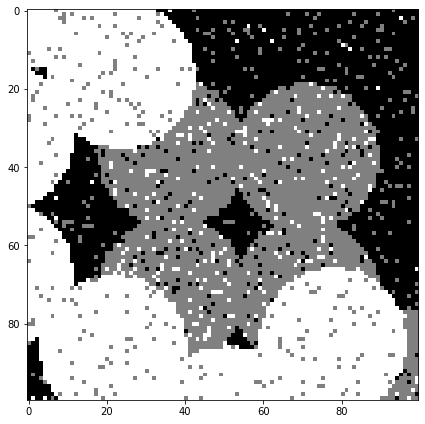

In [6]:
def thresholdConfig(thres1, thres2, img_noise):
    r, c = img_noise.shape
    config = np.zeros((r,c))
    for i in range(r):
        for j in range(c):
            val = img_noise[i,j]
            if val < thres1:
                config[i,j]=70.0
            elif thres1 < val and val < thres2:
                config[i,j]=130.0
            else:
                config[i,j]=190.0
    return config

config1 = thresholdConfig(100, 160, img_noise)

# Plots the thresholded segmentation:
fig1, f1_axes = plt.subplots(ncols=1, nrows=1, constrained_layout=False, figsize=(9,6))
f1_axes.imshow(config1, cmap = "gray")
fig1.show()
fig1.tight_layout()

In [7]:
# The segmentation energy is computed for the thresholding configuration:
segmentationEnergy(alpha, img_noise, config1)

Likelihood:  1650.4640000000002
Prior:  7321


8971.464

We see that the segmentation energy for the thresholding configuration is approx 8971, which is strictly greater than the energy computed for the optimal configuration.

### Second a configuration using median filtering is made:

-


### Graph Cuts for MRF:


In [8]:
d = np.array([179, 174, 182, 162, 175, 165])

In [9]:
import maxflow

In [10]:
# Testing the gender assignement case.
beta = 100
# Create a graph with integer capacities.
g = maxflow.Graph[float](2, 2)
# Add two (non-terminal) nodes. Get the index to the first one.
nodes = g.add_nodes(6)

g.add_edge(nodes[0], nodes[1], beta, beta)
g.add_edge(nodes[1], nodes[2], beta, beta)
g.add_edge(nodes[2], nodes[3], beta, beta)
g.add_edge(nodes[3], nodes[4], beta, beta)
g.add_edge(nodes[4], nodes[5], beta, beta)

# Set the capacities of the terminal edges...
clqe1 = (d-181)**2
clqe2 = (d-165)**2

g.add_tedge(nodes[0], clqe1[0], clqe2[0])
g.add_tedge(nodes[1], clqe1[1], clqe2[1])
g.add_tedge(nodes[2], clqe1[2], clqe2[2])
g.add_tedge(nodes[3], clqe1[3], clqe2[3])
g.add_tedge(nodes[4], clqe1[4], clqe2[4])
g.add_tedge(nodes[5], clqe1[5], clqe2[5])

#g.add_tedge(nodes[0], 2, 5)
# ...for the second node.
#g.add_tedge(nodes[1], 9, 4)

flow = g.maxflow()
print("Maximum flow:", flow)
print("Segment of the node 0:", g.get_segment(nodes[0]))
print("Segment of the node 1:", g.get_segment(nodes[1]))

opt_conf = []
for i in range(6):
    opt_conf.append(g.get_segment(nodes[i]))
print(opt_conf)
# Note: the get_segement returns 1 when the node belongs to the SOURCE, and 0 when the node belongs to the SINK.

Maximum flow: 263.0
Segment of the node 0: 1
Segment of the node 1: 1
[1, 1, 1, 0, 0, 0]


Big beta: Then contains big prior -> incentivices that neighbouring classes are the same.

beta=0: The classification will only rely on the likelihood term.

### We now perform image segmentation on the mouse tibia:

A tutorial can be found on:

http://pmneila.github.io/PyMaxflow/tutorial.html#getting-started

http://pmneila.github.io/PyMaxflow/maxflow.html


C:\Users\aabil\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


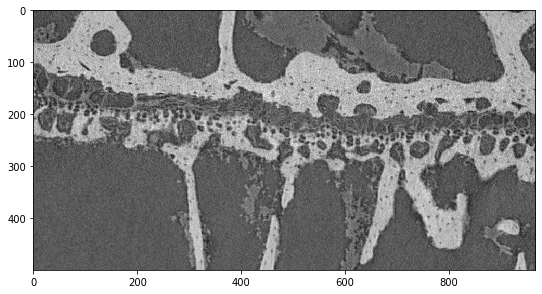

In [11]:
img_tibia = imageio.imread('data/data/V8_10X_x502.png').astype(float)*(1/(2**16-1))
#img_tibia = imageio.imread('data/data/noisy_circles.png').astype(float)*(1/(2**16-1))
fig2, f2_axes = plt.subplots(ncols=1, nrows=1, constrained_layout=False, figsize=(9,6))
f2_axes.imshow(img_tibia, cmap = "gray")
fig2.show()

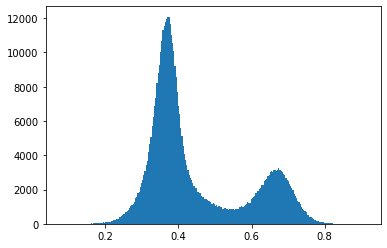

In [12]:
# Histogram for the mouse tibia picture:
segmentationHistogram(img_tibia, img_tibia, False)

From the histogram above we suggest initial mean intensities for the two classes as approximately 0.38 and 0.68

In [13]:
beta=0.02

# Create the graph.
g = maxflow.Graph[float]()
# Add the nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(img_tibia.shape)

# Create matrix describing neigbourhood structure:
structure=np.array([[0,1,0],
                    [1,0,1],
                    [0,1,0]])

# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, weights=beta, structure=structure, symmetric=True)

source_capacity = (0.38 - img_tibia)**2 #relies on first class
sink_capacity = (0.68 - img_tibia)**2 #relies on second class
# Note: 0.38 and 0.68 is determined from the histograms

# Add the terminal edges (likelihood weights):
g.add_grid_tedges(nodeids, source_capacity, sink_capacity)

In [14]:
# Find the maximum flow.
print("Maxflow: ", g.maxflow())
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids)
print(sgm)

Maxflow:  2157.970191998665
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


C:\Users\aabil\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


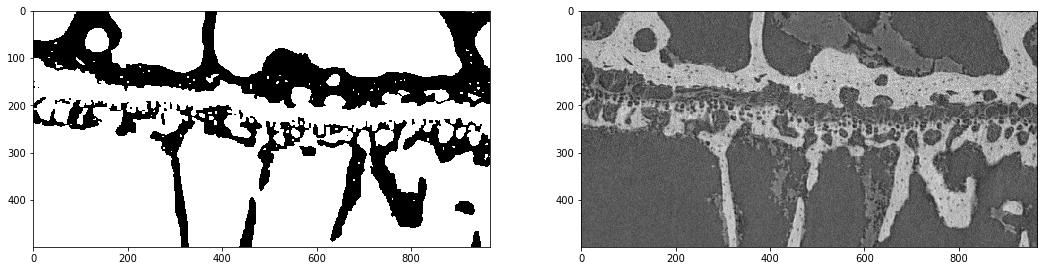

In [15]:
fig3, f3_axes = plt.subplots(ncols=2, nrows=1, constrained_layout=False, figsize=(18,12))
f3_axes[1].imshow(img_tibia, cmap = "gray")
f3_axes[0].imshow(sgm, cmap = "gray")
fig3.show()